In [1]:
import os

In [2]:
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.objects.log.adapters.pandas import csv_import_adapter
from pm4py.algo.discovery.dfg.adapters.pandas import df_statistics
from pm4py import util as pmutil

from pandas import read_csv
file = read_csv(os.path.join("files","input_data","sepsis.csv"))

log = csv_import_adapter.convert_timestamp_columns_in_df(file, timest_columns=[
    'timestamp'
])
dfg_frequency, dfg_performance = df_statistics.get_dfg_graph(log, measure="both",
                                                            activity_key='activity',
                                                            timestamp_key='timestamp',
                                                            case_id_glue='case_id')

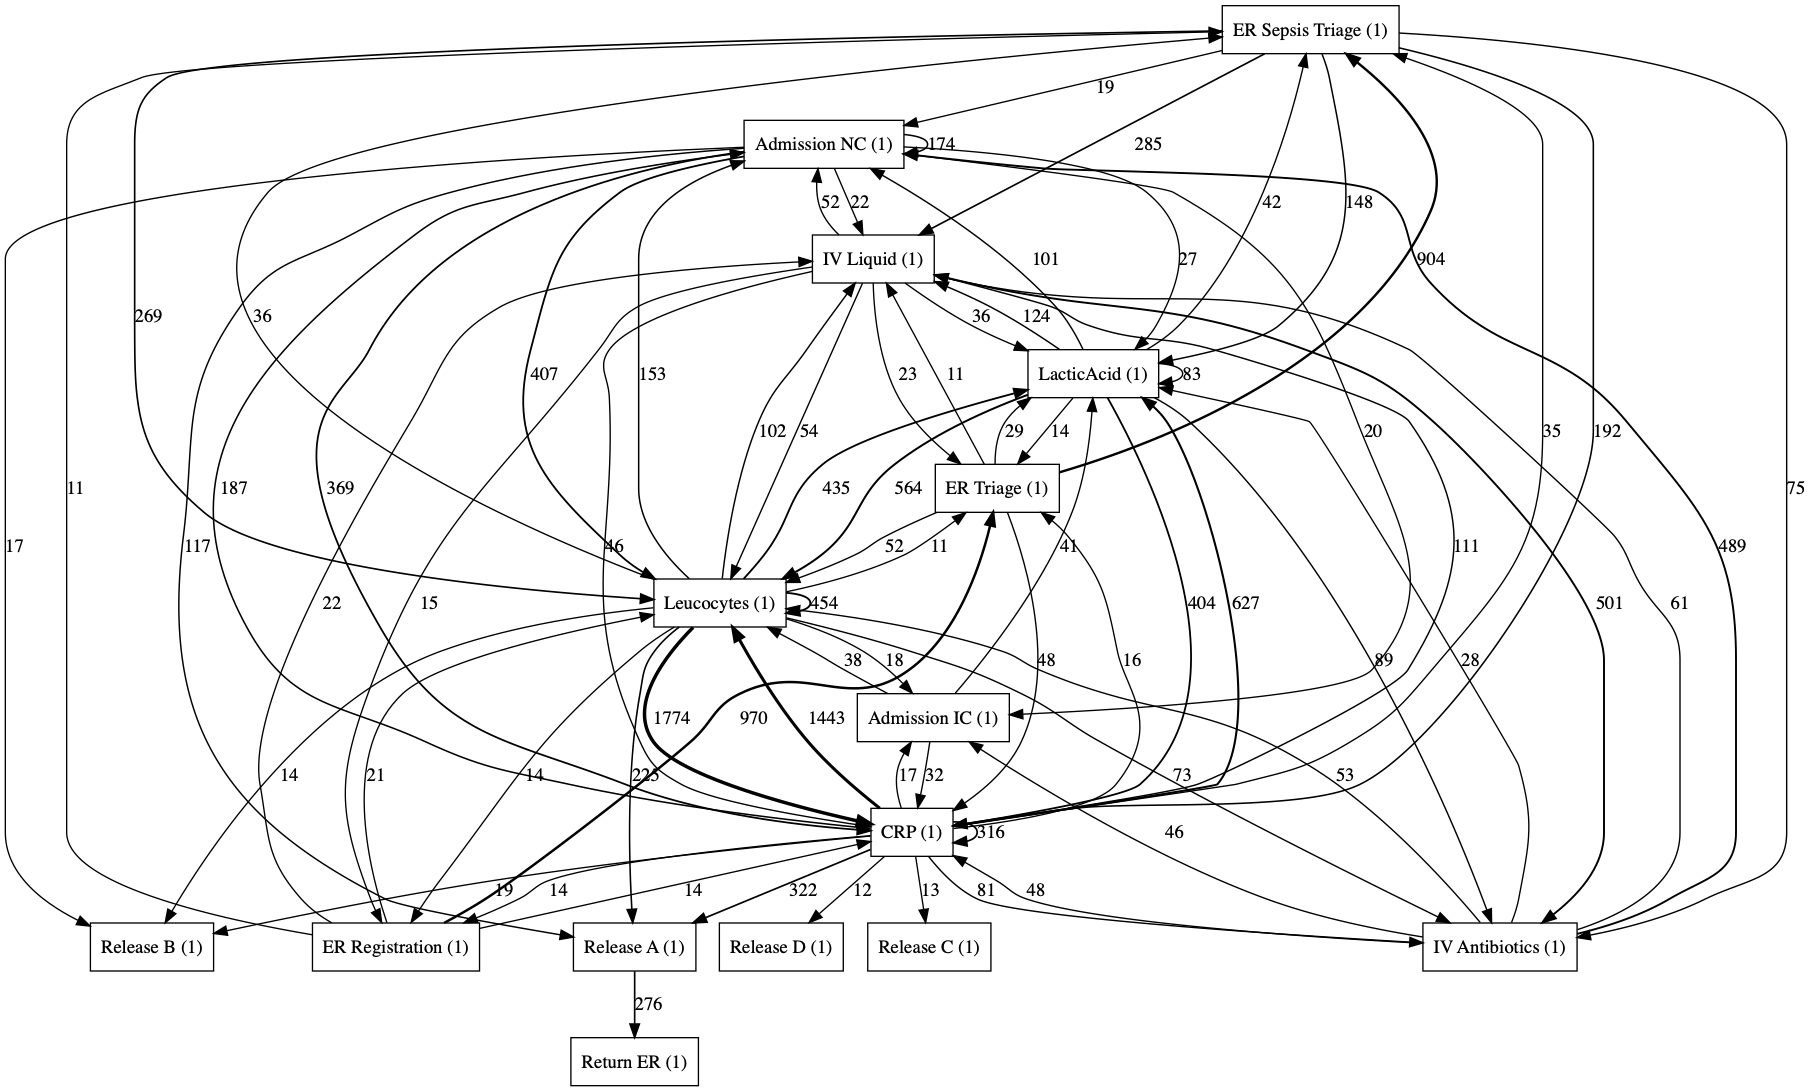

In [3]:
from pm4py.visualization.dfg import factory as dfg_vis_factory

gviz = dfg_vis_factory.apply(dfg_frequency, variant="frequency")
dfg_vis_factory.view(gviz)

In [4]:
from ntnu_process_mining import ProcessMap



activities = file.groupby('case_id').agg({'activity': lambda x: ''.join(x)}).groupby('activity')

process_map = ProcessMap()

def on_filter_change(change={}):
    filter_value=process_map.filter

    case_ids = activities.filter(lambda x: len(x) > filter_value).index

    filtered_log = log[log['case_id'].isin(case_ids)]
    dfg_frequency, dfg_performance = df_statistics.get_dfg_graph(filtered_log, measure="both",
                                                                activity_key='activity',
                                                                timestamp_key='timestamp',
                                                                case_id_glue='case_id')
    
    pm_edges = []
    # max_weight = max([freq for edge,freq in dfg_frequency.items()])
    for (src, dst), weight in dfg_frequency.items():
        # if max_weight*(process_map.filter/100) <= weight:
        pm_edges.append({"from": src, "to": dst, "value": weight})
    process_map.value=pm_edges

process_map.observe(on_filter_change, names='filter')

on_filter_change()
process_map

ProcessMap()